# Análisis de Grupos


In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
import seaborn as sns


### Lectura del archivo


In [7]:
df_houses = pd.read_csv('train.csv', encoding = "ISO-8859-1")
print(df_houses.head())
print(df_houses.shape)

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

### Variables numéricas


In [8]:
variables_numericas = [
    'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
    'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
    'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
    'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
    'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
    'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
    'MoSold', 'YrSold', 'SalePrice'
]

df_houses_num = df_houses[variables_numericas]

df_houses_temp = df_houses_num.copy()
df_houses_temp = df_houses_temp.fillna(df_houses_temp.median())

### Análisis para aplicación de PCA


**Matriz de correlación y Determinante**


In [9]:
corr_matrix = df_houses_temp.corr()

det = np.linalg.det(corr_matrix)
print(f'Determinante de la matriz de correlación: {det:.8f}')

Determinante de la matriz de correlación: -0.00000000


**Colinealidad entre pares**


In [10]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

threshold = 0.95

to_exclude = [column for column in upper.columns if any(upper[column] > threshold)]

print(f'Variables con correlación > {threshold}: {to_exclude}')

Variables con correlación > 0.95: []


**Clinealidad múltiple (VIF)**


In [11]:
X = df_houses_temp.values
vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif_df = pd.DataFrame({'Variable': df_houses_temp.columns, 'VIF': vif})

print("\n--- VIF (Factor de Inflación de Varianza) ---")
print(vif_df.sort_values('VIF', ascending=False))

c:\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



--- VIF (Factor de Inflación de Varianza) ---
         Variable           VIF
10    TotalBsmtSF           inf
7      BsmtFinSF1           inf
8      BsmtFinSF2           inf
9       BsmtUnfSF           inf
11       1stFlrSF           inf
12       2ndFlrSF           inf
13   LowQualFinSF           inf
14      GrLivArea           inf
34         YrSold  2.494748e+04
23    GarageYrBlt  2.251093e+04
5    YearRemodAdd  2.247548e+04
4       YearBuilt  2.149212e+04
21   TotRmsAbvGrd  8.386286e+01
2     OverallQual  7.482805e+01
3     OverallCond  4.225783e+01
24     GarageCars  3.715629e+01
20   KitchenAbvGr  3.330571e+01
35      SalePrice  3.215603e+01
25     GarageArea  3.205772e+01
19   BedroomAbvGr  3.135393e+01
17       FullBath  2.665179e+01
0     LotFrontage  1.562672e+01
33         MoSold  6.636915e+00
15   BsmtFullBath  3.692750e+00
18       HalfBath  3.418974e+00
22     Fireplaces  3.025670e+00
1         LotArea  2.679021e+00
26     WoodDeckSF  1.916944e+00
6      MasVnrArea  1.8676

**Evaluación de Esfericidad de Bartlett y KMO**


In [12]:
chi_cuadrado, p_valor = calculate_bartlett_sphericity(df_houses_temp)
kmo_all, kmo_modelo = calculate_kmo(df_houses_temp)

print(f'\nTest de Esfericidad de Bartlett:')
print(f' - Valor Chi-cuadrado: {chi_cuadrado:.4f}')
print(f' - Valor p: {p_valor:.4f}')

print(f'\nÍndice KMO: {kmo_modelo:.4f}')

if det < 1e-5:
    print("\nAlerta: La matriz de correlación es casi singular (multicolinealidad severa).")
    print("   Se recomienda revisar y eliminar variables redundantes.")
elif any(vif_df['VIF'] > 10):
    print("\nAlerta: Algunas variables tienen VIF > 10 (multicolinealidad múltiple severa).")
    print("   Considera revisar y ajustar el modelo eliminando variables redundantes.")
else:
    print("\nNo se detectó multicolinealidad severa. Puedes continuar con PCA sin problema.")

# Recomendación final para PCA
if (det > 1e-5) and (kmo_modelo >= 0.6) and (p_valor < 0.05):
    print("\nCondiciones estadísticas cumplidas para PCA (KMO aceptable y esfericidad válida).")
else:
    print("\nCuidado: Condiciones para PCA no son ideales. Considera revisar el dataset.")



Test de Esfericidad de Bartlett:
 - Valor Chi-cuadrado: nan
 - Valor p: nan

Índice KMO: 0.5965

Alerta: La matriz de correlación es casi singular (multicolinealidad severa).
   Se recomienda revisar y eliminar variables redundantes.

Cuidado: Condiciones para PCA no son ideales. Considera revisar el dataset.


c:\Python312\Lib\site-packages\factor_analyzer\factor_analyzer.py:109: RuntimeWarning: invalid value encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)


<small>

#### **Análisis de resultados**

1. Determinante de la matriz de correlación: -0.00000000

   Esto es una señal de multicolinealidad severa. Un determinante cercano a cero (o negativo) significa que hay variables redundantes o muy correlacionadas entre sí, al punto que la matriz es casi singular (no invertible matemáticamente). No es recomendable aplicar PCA hasta hacer limpieza.

2. VIFs infinitos (inf)

   Cuando el VIF es infinito (inf), significa que una variable se puede predecir perfectamente usando las demás variables. Esto es colinealidad perfecta, una de las peores situaciones para PCA o cualquier modelo lineal.

3. Fallo de Bartlett (p-valor nan)

   Esto es porque hay un problema matemático al calcular el determinante dentro del test.
   Si la matriz de correlación es singular (determinante = 0 o negativo), Bartlett no se puede calcular correctamente. Por eso aparece nan.

4. KMO = 0.5965 (Poco aceptable)

   Al tener un valor debajo de 0.6, se indica que no es recomendable aplicar PCA sin limpieza previa.

</small>


### Eliminación de variables con varianza baja (casi constantes)


Según los resultados las variables con valor inf indica una multicolinealidad perfecta (correlación lineal exacta con otras variables).


**Listado de variables a eliminar**


In [13]:
variables_a_eliminar = [
    'TotalBsmtSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
    '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',  
    'YrSold', 'GarageYrBlt', 'YearRemodAdd', 'YearBuilt'  
]

**Eliminación de variables en DataFrame temporal**


In [14]:
df_houses_temp = df_houses_temp.drop(columns=variables_a_eliminar)

print(f'Variables eliminadas: {variables_a_eliminar}')
print("-"*50)
print(f'\nNueva forma del dataframe temporal: {df_houses_temp.shape}')

Variables eliminadas: ['TotalBsmtSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'YrSold', 'GarageYrBlt', 'YearRemodAdd', 'YearBuilt']
--------------------------------------------------

Nueva forma del dataframe temporal: (1460, 24)


### Análisis de Esfericidad de Bartlett y KMO luego de limpieza


**Matriz de correlación**


In [15]:
corr_matrix = df_houses_temp.corr()
det = np.linalg.det(corr_matrix)
print(f'Determinante de la matriz de correlación (después de limpieza): {det:.8f}')

Determinante de la matriz de correlación (después de limpieza): 0.00083177


**Test de esfericidad de Bartlet**


In [16]:
chi_cuadrado, p_valor = calculate_bartlett_sphericity(df_houses_temp)

print(f'Resultado Test de Bartlett')
print(f'Chi-cuadrado: {chi_cuadrado}')
print(f'Valor p: {p_valor}')

Resultado Test de Bartlett
Chi-cuadrado: 10284.515968887566
Valor p: 0.0


**Test de KMO**


In [17]:
kmo, kmo_general = calculate_kmo(df_houses_temp)

print(f'Índice KMO General: {kmo_general:.4f}')

Índice KMO General: 0.7961


#### Análisis para aplicar PCA


In [18]:
if det < 0.000001:
    print('La matriz de correlación aún podría ser casi singular.')
if p_valor < 0.05:
    print('Bartlett indica que es posible aplicar PCA (matriz de correlación es significativamente diferente a identidad).')
else:
    print('Bartlett sugiere que PCA no es adecuado (matriz similar a identidad).')

if kmo_general < 0.6:
    print('KMO indica que la adecuación es pobre. PCA no es recomendable.')
elif kmo_general < 0.7:
    print('KMO regular, puedes aplicar PCA con precaución.')
else:
    print('KMO indica que la adecuación es aceptable o buena. Puedes aplicar PCA.')

Bartlett indica que es posible aplicar PCA (matriz de correlación es significativamente diferente a identidad).
KMO indica que la adecuación es aceptable o buena. Puedes aplicar PCA.


#### Análisis de resultados obtenidos


<small>

Tras realizar una serie de pruebas estadísticas sobre las variables cuantitativas seleccionadas, se evaluó si el dataset era adecuado para aplicar un **Análisis de Componentes Principales (PCA)**. Para ello, se realizaron las siguientes pruebas:

1. Determinante de la matriz de correlación
2. Test de Esfericidad de Bartlett
3. Índice de adecuación muestral KMO

En primer lugar, **el determinante de la matriz de correlación resultó ser 0.00083177**, un valor bajo que indica la presencia de colinealidad entre las variables. Este es un resultado esperado y deseado cuando se busca aplicar PCA, ya que este método es más efectivo cuando las variables tienen correlaciones significativas entre sí.

Por otro lado, el Test de Esfericidad de Bartlett arrojó un valor de **chi-cuadrado de 10284.52** con un **p-valor de 0.0**. Este resultado es altamente significativo (p < 0.05), lo que permite rechazar la hipótesis nula que indica que las variables son no correlacionadas (matriz identidad). _Esto significa que las variables tienen correlaciones suficientemente fuertes entre ellas_.

Finalmente, el Índice **KMO obtenido fue de 0.7961**, lo cual se interpreta como una adecuación muestral aceptable tirando a buena. El KMO evalúa si las correlaciones parciales entre pares de variables son lo suficientemente pequeñas para que PCA sea apropiado. Un valor cercano a 1 es deseado, mientras que valores por debajo de 0.6 indicarían problemas de adecuación. Con 0.7961, _se puede concluir que el dataset es razonablemente adecuado para aplicar PCA._

</small>


### Análisis de componentes


**Variables seleccionadas**


In [19]:
variables_seleccionadas = [
    'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFullBath',
    'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
    'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'WoodDeckSF',
    'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
    'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'
]

df_houses_pca_temp = df_houses[variables_seleccionadas].copy()

df_houses_pca_temp = df_houses_pca_temp.fillna(df_houses_pca_temp.median())

**Pipeline - Escalamiento y PCA**


In [20]:
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(df_houses_pca_temp)

modelo_pca = pca_pipe.named_steps['pca']

**Cantidad de componentes generados**


In [21]:
print(f'Cantidad de Componentes Generados: {len(modelo_pca.components_)}')

Cantidad de Componentes Generados: 21


**Resultado del PCA**


In [22]:
print("Resultado del PCA:")
df_cargas = pd.DataFrame(
    data=modelo_pca.components_,
    columns=df_houses_pca_temp.columns,
    index=[f'PC{i+1}' for i in range(modelo_pca.n_components_)]
)
display(df_cargas)

Resultado del PCA:


,OverallQual,OverallCond,MasVnrArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
PC1,0.390677,-0.084364,0.263504,0.067460,0.342043,0.206607,0.183858,-0.020245,0.341840,0.263559,...,0.176653,0.200678,-0.086987,0.014408,0.061274,0.057166,-0.015106,0.039575,-0.026024,0.422237
PC2,-0.162725,0.002956,-0.104116,-0.352141,0.196949,0.076582,0.538052,0.446723,0.411448,-0.126462,...,-0.177486,-0.034416,0.168538,-0.048202,-0.051131,0.011244,0.085605,0.043677,-0.051383,-0.149538
PC3,-0.014624,0.511947,-0.105337,-0.041968,-0.218935,0.194860,0.128850,-0.282017,0.063089,0.290162,...,-0.057742,0.139612,0.184817,-0.076806,0.467124,0.290807,0.220715,0.009116,-0.064589,0.017236
PC4,-0.060407,0.083387,0.049764,0.315057,-0.024556,-0.035366,0.070543,0.178138,0.105362,0.053227,...,0.249982,-0.229240,0.154646,-0.112993,-0.088320,0.168975,0.139809,-0.554000,0.563818,0.038361
PC5,-0.002251,-0.083906,-0.117457,0.274716,0.022335,-0.289283,-0.018637,0.084075,0.005334,0.062912,...,0.241210,-0.026617,0.380684,-0.166378,-0.297972,0.509749,0.024071,0.232842,-0.414460,0.036710
PC6,0.108766,0.464513,-0.051572,-0.153148,0.074163,-0.106697,0.029355,-0.160671,0.028927,-0.026292,...,0.179059,-0.108953,0.176989,0.615886,-0.419373,-0.148776,0.133337,0.127076,0.090599,0.080254
PC7,-0.067460,0.000755,-0.032950,0.276685,0.046276,-0.251129,-0.072263,0.387273,-0.007261,0.031021,...,0.019343,-0.025701,-0.345632,0.231975,0.305468,0.006967,0.560208,0.330888,0.067420,0.012102
PC8,-0.074839,0.261139,-0.103674,0.001082,-0.065437,0.179579,0.111252,-0.044122,0.034472,-0.086709,...,0.547143,0.017266,-0.364533,-0.491983,-0.221459,-0.252846,0.078708,0.226366,-0.020497,-0.048266
PC9,0.088086,-0.174351,0.107033,-0.298774,0.033808,0.153310,-0.158963,-0.158594,-0.087575,-0.124111,...,-0.071703,0.000178,0.002008,-0.134494,-0.222294,0.059455,0.720602,-0.322847,-0.237374,0.004694
PC10,-0.130860,-0.092986,-0.152735,0.018601,-0.024481,0.271840,0.099715,-0.032094,0.003179,-0.172901,...,0.153292,0.233623,-0.476637,0.393101,-0.111486,0.529786,-0.131619,-0.195366,-0.066959,-0.100464


**Visualización de las cargas con matriz de calor**


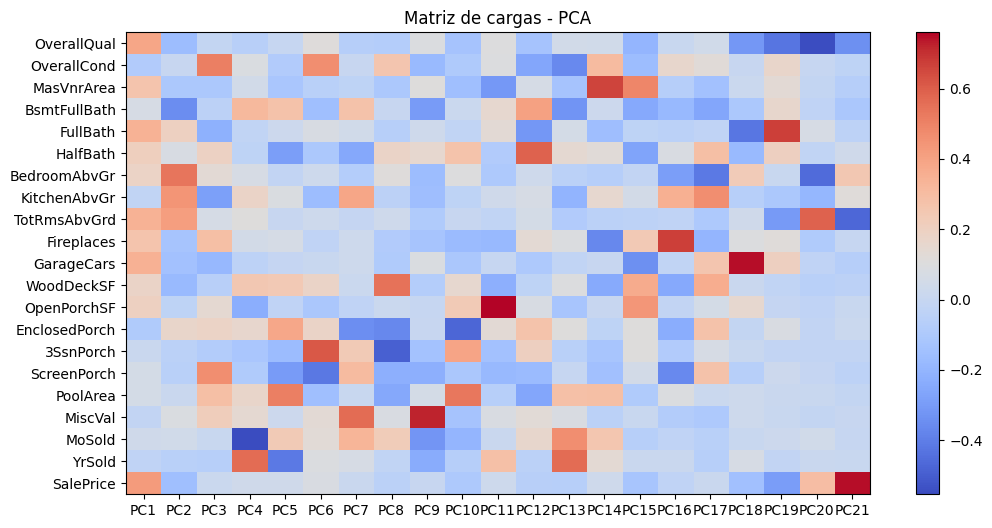

In [23]:
plt.figure(figsize=(12, 6))
plt.imshow(modelo_pca.components_.T, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.yticks(range(len(df_houses_pca_temp.columns)), df_houses_pca_temp.columns)
plt.xticks(range(modelo_pca.n_components_), [f'PC{i+1}' for i in range(modelo_pca.n_components_)])
plt.title('Matriz de cargas - PCA')
plt.show()

**Varianza explicada por componente**


Porcentaje de varianza explicada por cada componente:

[0.20704066 0.08575208 0.06073409 0.05698193 0.05315861 0.05008486
 0.04931933 0.04744086 0.04549111 0.04520472 0.04251504 0.04081704
 0.03756527 0.03463564 0.03078169 0.02986314 0.02936188 0.02003839
 0.01539363 0.01024867 0.00757135]


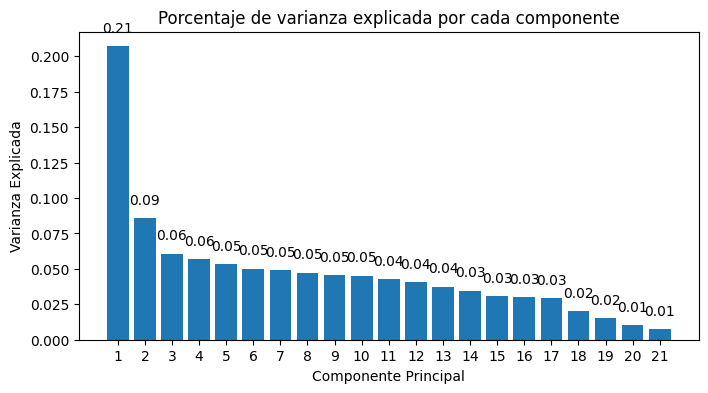

In [24]:
print('Porcentaje de varianza explicada por cada componente:\n')
print(modelo_pca.explained_variance_ratio_)

# Gráfico de varianza explicada
plt.figure(figsize=(8, 4))
plt.bar(
    x=np.arange(modelo_pca.n_components_) + 1,
    height=modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(modelo_pca.n_components_) + 1, modelo_pca.explained_variance_ratio_):
    plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

plt.xticks(np.arange(modelo_pca.n_components_) + 1)
plt.title('Porcentaje de varianza explicada por cada componente')
plt.xlabel('Componente Principal')
plt.ylabel('Varianza Explicada')
plt.show()

**Varianza explicada acumulada**


Porcentaje de varianza explicada acumulada:

[0.20704066 0.29279274 0.35352684 0.41050877 0.46366738 0.51375225
 0.56307158 0.61051244 0.65600355 0.70120827 0.7437233  0.78454034
 0.82210561 0.85674125 0.88752294 0.91738608 0.94674796 0.96678635
 0.98217998 0.99242865 1.        ]


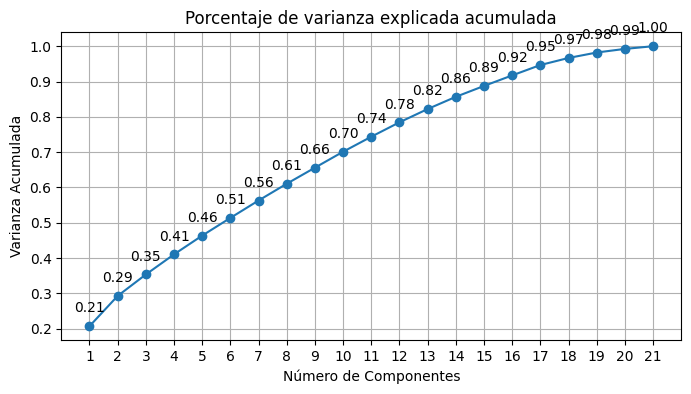

In [25]:
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()

print('Porcentaje de varianza explicada acumulada:\n')
print(prop_varianza_acum)

# Gráfico de varianza acumulada
plt.figure(figsize=(8, 4))
plt.plot(np.arange(len(variables_seleccionadas)) + 1, prop_varianza_acum, marker='o')

for x, y in zip(np.arange(len(variables_seleccionadas)) + 1, prop_varianza_acum):
    plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

plt.xticks(np.arange(modelo_pca.n_components_) + 1)
plt.title('Porcentaje de varianza explicada acumulada')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.grid(True)
plt.show()

**Carga de primeros 4 componentes**


In [26]:
print("Cargas de los primeros 4 componentes principales:")
for i in range(4):
    print(f'Componente {i+1}:')
    for j, variable in enumerate(df_houses_pca_temp.columns):
        print(f'  {variable}: {modelo_pca.components_[i, j]:.3f}')
    print('---')

Cargas de los primeros 4 componentes principales:
Componente 1:
  OverallQual: 0.391
  OverallCond: -0.084
  MasVnrArea: 0.264
  BsmtFullBath: 0.067
  FullBath: 0.342
  HalfBath: 0.207
  BedroomAbvGr: 0.184
  KitchenAbvGr: -0.020
  TotRmsAbvGrd: 0.342
  Fireplaces: 0.264
  GarageCars: 0.345
  WoodDeckSF: 0.177
  OpenPorchSF: 0.201
  EnclosedPorch: -0.087
  3SsnPorch: 0.014
  ScreenPorch: 0.061
  PoolArea: 0.057
  MiscVal: -0.015
  MoSold: 0.040
  YrSold: -0.026
  SalePrice: 0.422
---
Componente 2:
  OverallQual: -0.163
  OverallCond: 0.003
  MasVnrArea: -0.104
  BsmtFullBath: -0.352
  FullBath: 0.197
  HalfBath: 0.077
  BedroomAbvGr: 0.538
  KitchenAbvGr: 0.447
  TotRmsAbvGrd: 0.411
  Fireplaces: -0.126
  GarageCars: -0.139
  WoodDeckSF: -0.177
  OpenPorchSF: -0.034
  EnclosedPorch: 0.169
  3SsnPorch: -0.048
  ScreenPorch: -0.051
  PoolArea: 0.011
  MiscVal: 0.086
  MoSold: 0.044
  YrSold: -0.051
  SalePrice: -0.150
---
Componente 3:
  OverallQual: -0.015
  OverallCond: 0.512
  MasVnrA

**Matriz reducida**


In [27]:
X_reducido = modelo_pca.transform(df_houses_pca_temp)

print("Matriz reducida (primeras 5 filas):")
print(pd.DataFrame(X_reducido, columns=[f'PC{i+1}' for i in range(modelo_pca.n_components_)]).head())

Matriz reducida (primeras 5 filas):
             PC1           PC2          PC3           PC4          PC5  \
0   88055.430665 -31300.220912  3454.229085   9126.560635  6797.300332   
1   76642.582817 -27293.396781  2985.442695   8167.173063  5903.582443   
2   94376.076157 -33539.742107  3713.920410   9700.610671  7354.133876   
3   59051.415613 -20990.564879  2341.064856   6535.915068  4411.060605   
4  105659.315090 -37555.996401  4145.780902  10763.542244  8350.751015   

            PC6          PC7           PC8         PC9          PC10  ...  \
0  16901.525492  2651.200159 -10122.247249  520.986183 -21098.418538  ...   
1  14806.532365  2339.237854  -8635.524239  350.733722 -18325.651586  ...   
2  18109.964458  2836.707950 -10841.613631  585.551458 -22606.176706  ...   
3  11465.010401  1735.428711  -6895.582676  179.314255 -14322.792874  ...   
4  20257.415686  3154.721473 -12033.651843  715.097937 -25258.670634  ...   

           PC12          PC13         PC14          PC15

c:\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


<small>

**Análisis de resultados obtenidos mediante el análisis de PCA**

1. Porcentaje de varianza acumulada:

   En base a los resultados obtenidos, se observa lo siguiente:

   - El primer componente (PC1) explica aproximadamente el **20.7%** de la varianza total.
   - Con los primeros **5 componentes**, ya se alcanza aproximadamente el **46.4%** de la varianza explicada.
   - Si se consideran los **10 primeros componentes**, se logra explicar el **70%** de la varianza total.
   - Al llegar al **componente 15**, se alcanza el **89%** de varianza acumulada, lo cual es coherente con la **regla del 80%-90%**, recomendada para retener suficiente información del dataset original.

   Esta tendencia muestra que el dataset es bastante complejo y disperso, lo cual requiere un número relativamente alto de componentes para representar adecuadamente la información contenida en las variables originales.

2. Cojo de Jambú

   Al analizar la gráfica de **varianza explicada acumulada**, es posible identificar un claro "codo" entre los componentes **15 y 17**. Esto sugiere que, más allá de ese punto, agregar componentes adicionales **aporta una cantidad marginal** de varianza explicada, es decir, la ganancia es muy baja comparada con los primeros componentes.

3. Conclusión

   Tomando en cuenta:

   - La **regla de 80%-90%** de varianza explicada.
   - El punto de inflexión observado en el **Codo de Jambú**.
   - La **complejidad y cantidad de variables** en el dataset original.

   Se decide conservar **15 componentes principales**, que explican el **89% de la varianza total**, permitiendo una reducción significativa de dimensiones sin perder información crítica.

**Explicación por componente**

A continuación, se presenta una tabla resumen con la interpretación de cada uno de los **primeros 15 componentes** seleccionados, destacando las variables con mayores cargas (peso) en cada uno y la interpretación general que se les asigna:

| Componente | Variables más relevantes                       | Interpretación                                                                                                      |
| ---------- | ---------------------------------------------- | ------------------------------------------------------------------------------------------------------------------- |
| **PC1**    | OverallQual, FullBath, TotRmsAbvGrd, SalePrice | Representa la **calidad general, tamaño y valor económico** de las casas. Es el componente más importante.          |
| **PC2**    | BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd       | Relacionado con la **distribución interna** (cantidad de habitaciones y cocinas).                                   |
| **PC3**    | OverallCond, ScreenPorch, PoolArea             | Explica la **condición general y la presencia de amenidades exteriores** (porches y piscina).                       |
| **PC4**    | BsmtFullBath, YrSold, MoSold                   | Relacionado con **baños completos en sótano** y **temporalidad** (año y mes de venta).                              |
| **PC5**    | EnclosedPorch, PoolArea, MiscVal               | Captura información sobre **espacios exteriores cerrados y elementos especiales** como piscinas y otras amenidades. |
| **PC6**    | OverallCond, Fireplaces, 3SsnPorch             | Condición general combinada con **elementos de confort** como chimeneas y porches de 3 estaciones.                  |
| **PC7**    | KitchenAbvGr, BsmtFullBath, BsmtHalfBath       | Configuración interna enfocada en **baños y cocinas**.                                                              |
| **PC8**    | WoodDeckSF, EnclosedPorch, 3SsnPorch           | Describe principalmente los **espacios exteriores** (decks, porches).                                               |
| **PC9**    | MiscVal, MoSold, YrSold                        | Relacionado con **valores atípicos o extras** (MiscVal) y la **temporalidad de venta**.                             |
| **PC10**   | HalfBath, MiscVal, EnclosedPorch               | Explica **comodidades secundarias y extras**.                                                                       |
| **PC11**   | OpenPorchSF, EnclosedPorch, MiscVal            | Otros detalles de **porches abiertos/cerrados y elementos menores**.                                                |
| **PC12**   | BsmtFullBath, FullBath, MoSold                 | Componente centrado en **baños y momento de venta**.                                                                |
| **PC13**   | OverallCond, BsmtHalfBath, MiscVal             | Condición y características **poco frecuentes** del inmueble.                                                       |
| **PC14**   | MasVnrArea, Fireplaces, GarageCars             | Variables asociadas a **construcción exterior, confort y capacidad de garaje**.                                     |
| **PC15**   | PoolArea, KitchenAbvGr, SalePrice              | Mezcla entre **amenidades exteriores, distribución interna y precio final**.                                        |

**Nota final**

Este análisis muestra cómo **PCA** permite reducir 21 variables originales a **15 componentes**, reteniendo casi el **90%** de la información relevante. Estos componentes resumen patrones latentes sobre la **calidad de las casas, su tamaño, su distribución interna, sus amenidades, y la temporalidad de la venta**, lo cual facilita el análisis posterior, modelos predictivos o segmentación.

</small>


### CSV con resultados de PCA


In [ ]:
pca_reducido_df = pd.DataFrame(
    X_reducido[:, :15],  
    columns=[f'PC{i+1}' for i in range(15)]
)

pca_reducido_df['Id'] = df_houses['Id'].values  
pca_reducido_df['SalePrice'] = df_houses['SalePrice'].values  

pca_reducido_df.to_csv('pca_resultados.csv', index=False)

print("Archivo 'pca_resultados.csv' creado con éxito.")

✅ Archivo 'pca_resultados.csv' creado con éxito.
